Progress Report 1
----

**Team Members**

Yaqian Cheng, Department of Statistical Science

Mengrun Li, Department of Statistical Science

**Github repository**

<https://github.com/cici7941/Sta_663_Statistical_Computation_Final_Project>

**Choice of paper** 

*Scalable K-Means++*

**Abstract**

*K-means* is one of the most popular clustering methods. A good initialization of *k-means* is essential for obtaining the global optimal solution and efficiency. However, there are two main obstacles with traditional *k-means* method. One is theoretical inefficiency and the other one is that its final solution is locally optimal. A better algorithm, *k-means++* addresses the second problem with an improved initialization procedure of the cluster centers. But this *k-means++* initialization is not parallelizable, because the selection for the *i*th center depends on the previous *i-1* centers [1]. Therefore, *k-means||*, a parallelizable version of *k-means++*, has been raised, which can both improve the final solution and run faster. In this report, we implemented the algorithm in the paper "Scalable K-Means++" in Python, compared the clustering cost and runtime between *k-means*, *k-means++* and *k-means||*, performed tests for main functions, profiled the performance of the algorithm and identified bottlenecks, and performed optimization using Cython. We then apply *k-means||* to a massive dataset to evaluate its performance.

**Outline**

1. Introduction
2. Algorithm  
    2.1 K-Means  
    2.2 K-Means++  
    2.3 K-Means||  
3. Code Testing
4. Profiling and Optimization
5. Application and Comparison

In [5]:
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# helper functions
def euc_dist(x, y):
    return la.norm(x-y)

def centroid(X):
    return X.mean(0)
    
def d(x, Y):
    minDist = float("inf")
    for yi in Y:
        dist = euc_dist(x, yi)
        if(dist < minDist):
            minDist = dist
    return minDist

def cost(Y, C):
    cost = 0
    for yi in Y:
        cost += d(yi, C)**2
    return cost

In [3]:
# K-Means++
def kmeansPlus(data, k):
    idx = np.random.choice(data.shape[0], 1)
    C = data[idx, :]
    while(C.shape[0] < k):
        prob = [d(xi,C)**2 for xi in data]/cost(data,C)
        new = data[np.random.choice(data.shape[0], size=1, p=prob),:]
        if(new.tolist() not in C.tolist()):
            C = np.r_[C, new]
    return C

**Initialization algorithm: k-means||**  
*k-means||* uses an oversampling factor *l* = $\Omega$(k), which is unlike *k-means++*. Intuitively, *l* should be thought of as $\Theta$(k). This initialization algorithm picks an initial center uniformly from the dataset and computes $\psi$, here is initial cost of the clustering of this selection. Then do log$\psi$ iterations and in each iteration, it samples each x with probability *l*$d^2(x,C)/\psi_X(C)$ given current set C of centers. If the point is sampled, it will be added to C and the quantity $\phi_X(C)$ updated and interation continued.

***Algorithm*** *k-means||*(k,l)initialization  
1. C <- sample a point uniformly at random from X  
2. $\psi$ = $\phi_X(C)$  
3. for O(log$\psi$) times do  
      C' <- sample each point x $\in$ X independently with probability $p_x = \frac{l*d^2(x,C)}{\phi_X(C)}$  
      C <- C $\cup$ C'  
   end for  
4. For x $\in$ C, set $w_x$ to be the number of points in X closer to x than any other point in C  
5. Recluster the weighted points in C into k clusters

[7]
first centroid: [[  9.  12.]]
initial cost: 934.77


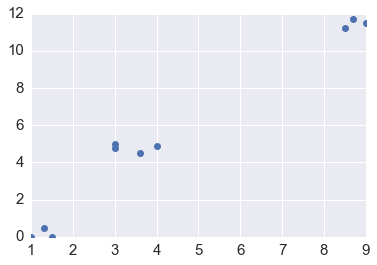

In [154]:
# K-Means||
X_ori = np.array([[1,0],[1.5,0],[3,5],[3,4.8],[3.6,4.5],[4,4.9],[9,12],[9,11.5],[8.7,11.7],[8.5,11.2],[1.3,0.5]])
X = X_ori
k = 3
l = 2
##step1
##Sample a point uniformly at random from X
idx1 = np.random.choice(X_ori.shape[0],1,replace = False)
C = X[idx1-1,:]
print(idx1)
print("first centroid:",C)
##step2
##initial cost
gamma1 = cost(X,C)
print("initial cost:",gamma1)
##remove first centroid
X = np.delete(X, idx1-1, axis=0)
X
plt.plot(X[:,0],X[:,1],"o")

In [155]:
##step3-6
for i in range(int(round(np.log(gamma1))/k)):
    Ct = []
    idx = []
    gamma = cost(X,C)
    prob = [l*d(x,C)**2/gamma for x in X]
    #new = data[np.random.choice(X.shape[0], size=1, p=prob),:]
    for j in range(len(X)):
        point = np.random.binomial(1,prob[j],size = 1)
        if point == 1:
           Ct.append(X[j,:])
           idx.append(j)
    X = np.delete(X, idx, axis = 0)
    C = np.concatenate((C,np.array(Ct).reshape(len(Ct),2)),axis = 0)
C

array([[  9. ,  12. ],
       [  1.5,   0. ],
       [  4. ,   4.9],
       [  3. ,   5. ]])

In [164]:
##step7
w = []
for c in C:
    distxc = [euc_dist(x,c) for x in X]
    distc = [euc_dist(y,c) for y in C]
    distc.remove(0)
    count = 0
    for p in distxc:
        if p < min(distc):
           count += 1
    w.append(count)
w

[3, 4, 1, 2]

In [171]:
##step8
w_prob = w/np.sum(w)
w_prob
centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
centroid

array([3, 1, 0])